# Experiments with projective transforms

This Notebook is needed to get acquainted with projective transforms in Scikit-image.

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import transform
# NumPy (for fast vectorised computations)
import numpy as np
# Math (for trigonometry)
from math import cos, sin, asin
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/Moscow.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

## Step 1. Image load

In [4]:
image = io.imread(IM_PATH)

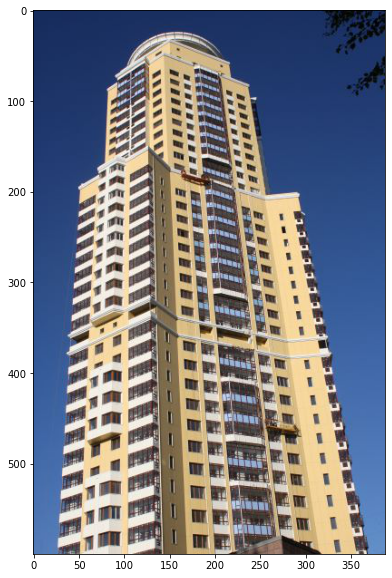

In [5]:
render_image(image)

Vanishing points detected with Hough transforms.

In [6]:
v_h, v_v = (484, 1490), (-676, 116)

## Step 2. Estimate the focal length

We will use estimation based on the length of image diagonal in pixels (see, e.g., [A. Gallagher, 2005] (Kodak, http://chenlab.ece.cornell.edu/people/Andy/publications/Andy_files/rotation_crv2005.pdf)).

In [7]:
focal_length = int((image.shape[0]**2 + image.shape[1]**2)**.5)

In [8]:
focal_length

714

## Step 3. Test of transforms

We need to translate the image such that its origin lies on the intersection of the vertical line going through the vertical vanishing point and the horizontal line going through the horizontal vanishing point.

Chain of transforms:

origin shift $\rightarrow$ from 2D to 3D with $z = $ focal length $\rightarrow$ rotate $\rightarrow$ from 3D to 2D $\rightarrow$ inversed origin shift.

In [9]:
# 1. Shift the origin of the image
#    [3 x 3]
origin_shift = np.array([[1, 0, -v_v[1]],
                         [0, 1, -v_h[0]],
                         [0, 0,   1   ]])

# 2. Go from uniform 2D to uniform 3D: (x, y, 1) -> (x, y, focal length, 1)
#    [4 x 3]
dim_shift_2to3 = np.array([[1, 0,      0      ],
                           [0, 1,      0      ],
                           [0, 0, focal_length],
                           [0, 0,      1      ]])

# 3. Spin the world about the X axis by 0.5 radians
#    [4 x 4]
spin_x = np.array([[1,    0    ,     0    , 0],
                   [0, cos(0.5), -sin(0.5), 0],
                   [0, sin(0.5),  cos(0.5), 0],
                   [0,    0    ,     0    , 1]])

# 4. Spin the world about the Y axis by 0.27 radians
#    [4 x 4]
spin_y = np.array([[ cos(0.27), 0, sin(0.27), 0],
                   [     0    , 1,     0    , 0],
                   [-sin(0.27), 0, cos(0.27), 0],
                   [     0    , 0,     0    , 1]])

# 5. Go from uniform 3D to uniform 2D: (x, y, z, 1) -> (x, y, 1)
#    [3 x 4]
dim_shift_3to2 = np.array([[1, 0,        0        , 0],
                           [0, 1,        0        , 0],
                           [0, 0, focal_length**-1, 0]])

# 6. Shift the origin back
#    [3 x 3]
inv_origin_shift = np.array([[1, 0, v_v[1]],
                             [0, 1, v_h[0]],
                             [0, 0,   1   ]])

In [10]:
# Resulting transform matrix
# [3 x 3] x [3 x 4] x [4 x 4] x [4 x 4] x [4 x 3] x [3 x 3] = [3 x 3]
transform_matrix = inv_origin_shift @ dim_shift_3to2 @ spin_y @ spin_x @ dim_shift_2to3 @ origin_shift

In [11]:
transform_matrix

array([[ 9.20436377e-01,  2.02945846e-01,  6.02473647e+01],
       [-1.80809545e-01,  1.19079725e+00, -4.88320147e+02],
       [-3.73573441e-04,  6.47137789e-04,  5.75908362e-01]])

In [12]:
major_transform = transform.EuclideanTransform(matrix=transform_matrix)

Let us also transform the image in a way so that it fits the borders.

In [13]:
# Initial corner points of the image
corner_tl_orig = np.array([[0], [0], [1]])
corner_tr_orig = np.array([[0], [image.shape[0] - 1], [1]])
corner_bl_orig = np.array([[image.shape[1] - 1], [0], [1]])
corner_br_orig = np.array([[image.shape[1] - 1], [image.shape[0] - 1], [1]])
# Transformed points
corner_tl_trans = transform_matrix @ corner_tl_orig
corner_tr_trans = transform_matrix @ corner_tr_orig
corner_bl_trans = transform_matrix @ corner_bl_orig
corner_br_trans = transform_matrix @ corner_br_orig
corners_trans = np.hstack([corner_tl_trans, corner_tr_trans, corner_bl_trans, corner_br_trans])
corners_trans[[0, 1]] = corners_trans[[1, 0]]
# Bounding box
bbox_tl = np.array([[np.min(corners_trans[0, :] / corners_trans[2, :])], [np.min(corners_trans[1, :] / corners_trans[2, :])]])
bbox_tr = np.array([[np.min(corners_trans[0, :] / corners_trans[2, :])], [np.max(corners_trans[1, :] / corners_trans[2, :])]])
bbox_bl = np.array([[np.max(corners_trans[0, :] / corners_trans[2, :])], [np.min(corners_trans[1, :] / corners_trans[2, :])]])
bbox_br = np.array([[np.max(corners_trans[0, :] / corners_trans[2, :])], [np.max(corners_trans[1, :] / corners_trans[2, :])]])
bbox_width = bbox_tr[1][0] - bbox_tl[1][0]
bbox_height = bbox_br[0][0] - bbox_tr[0][0]
print(bbox_width, bbox_height)

# Translation
fit_border_translation = np.array([[1, 0, -bbox_tl[1][0]],
                                   [0, 1, -bbox_tl[0][0]],
                                   [0, 0,        1     ]])
# Scale
fit_border_scale = min((image.shape[1] / bbox_width, image.shape[0] / bbox_height))
fit_border_scale = np.array([[fit_border_scale,        0        , 0],
                             [       0        , fit_border_scale, 0],
                             [       0        ,        0        , 1]])

# 7. Fit the borders
fit_border_matrix = fit_border_scale @ fit_border_translation

860.8915849041509 1527.8161966889945


In [14]:
fit_border_matrix

array([[ 3.92717397e-01,  0.00000000e+00, -4.10832518e+01],
       [ 0.00000000e+00,  3.92717397e-01,  5.08308677e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [15]:
fit_border_transform = transform.EuclideanTransform(matrix=fit_border_matrix)

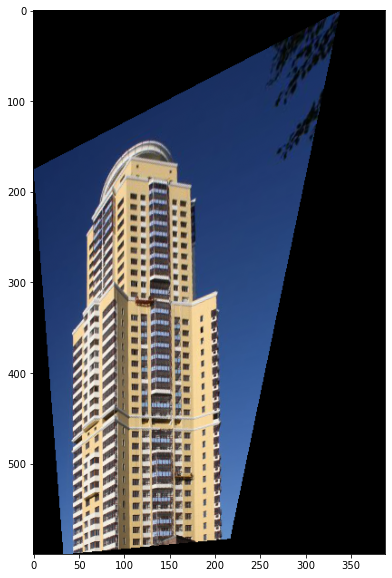

In [16]:
render_image(transform.warp(image, (major_transform + fit_border_transform).inverse))

## Step 4. Automatic identification of rotation angles

In [17]:
def estimate_xy_rotation(image, v_v, v_h):
    """
    Estimate angles of rotation for elimination of vanishing points
    
    Parameters
    ==========
    """
    # 1. Find out focus length
    focus_length = int((image.shape[0]**2 + image.shape[1]**2)**.5)
    
    # 2. Find radius-vectors of vanishing points in 3D
    v_v_3d = np.array([[v_v[0] - v_h[0]], [0], [focus_length]])
    v_h_3d = np.array([[0], [v_h[1] - v_v[1]], [focus_length]])
    
    # 3. Normalise radius-vectors to only have directions
    v_v_3d_n = v_v_3d / np.linalg.norm(v_v_3d)
    v_h_3d_n = v_h_3d / np.linalg.norm(v_h_3d)
    
    # 4. Specify t_x and phi_x right away
    cos_x = v_v_3d_n[2]
    t_x = v_v[1]
    phi_x = asin(cos_x)
    
    # 5. We need v_h_3d to be a radius-vector of v_h after rotation about X axis.
    #    Let us apply the inverse rotation to see where the initial vector must be
    inverse_spin_x = np.array([[ cos(-phi_x), 0, sin(-phi_x)],
                               [      0     , 1,      0     ],
                               [-sin(-phi_x), 0, cos(-phi_x)]])
    v_h_3d_original = inverse_spin_x @ v_h_3d
    
    # 6. Specify t_y and phi_y
    cos_y = v_h_3d_n[2]
    t_y = v_h[0] + int(v_h_3d_original[0])
    phi_y = asin(cos_y) if v_h[1] > v_v[1] else -asin(cos_y)
    
    return t_x, t_y, phi_x, phi_y

In [18]:
def apply_xy_rotation(image, t_x, t_y, phi_x, phi_y):
    focus_length = int((image.shape[0]**2 + image.shape[1]**2)**.5)
    
    # 1. Make up the major transformation, i.e. 3D rotation
    # 1.1. Shift the origin of the image
    #      [3 x 3]
    origin_shift = np.array([[1, 0, -t_x],
                             [0, 1, -t_y],
                             [0, 0,   1 ]])

    # 1.2. Go from uniform 2D to uniform 3D: (x, y, 1) -> (x, y, focal length, 1)
    #      [4 x 3]
    dim_shift_2to3 = np.array([[1, 0,      0      ],
                               [0, 1,      0      ],
                               [0, 0, focal_length],
                               [0, 0,      1      ]])

    # 1.3. Spin the world about the X axis by phi_x radians
    #      [4 x 4]
    spin_x = np.array([[1,     0     ,      0     , 0],
                       [0, cos(phi_x), -sin(phi_x), 0],
                       [0, sin(phi_x),  cos(phi_x), 0],
                       [0,     0     ,      0     , 1]])

    # 1.4. Spin the world about the Y axis by phi_y radians
    #      [4 x 4]
    spin_y = np.array([[ cos(phi_y), 0, sin(phi_y), 0],
                       [     0     , 1,     0     , 0],
                       [-sin(phi_y), 0, cos(phi_y), 0],
                       [     0     , 0,     0     , 1]])

    # 1.5. Go from uniform 3D to uniform 2D: (x, y, z, 1) -> (x, y, 1)
    #      [3 x 4]
    dim_shift_3to2 = np.array([[1, 0,        0        , 0],
                               [0, 1,        0        , 0],
                               [0, 0, focal_length**-1, 0]])

    # 1.6. Shift the origin back
    #      [3 x 3]
    inv_origin_shift = np.array([[1, 0, t_x],
                                 [0, 1, t_y],
                                 [0, 0,  1 ]])
    
    # 1.7. Resulting rotation transform
    #      [3 x 3] x [3 x 4] x [4 x 4] x [4 x 4] x [4 x 3] x [3 x 3] = [3 x 3]
    transform_matrix = inv_origin_shift @ dim_shift_3to2 @ spin_y @ spin_x @ dim_shift_2to3 @ origin_shift
    major_transform = transform.EuclideanTransform(matrix=transform_matrix)
    
    # 2. Make the resulting image fit into the borders
    # 2.1. Initial corner points of the image
    corner_tl_orig = np.array([[0], [0], [1]])
    corner_tr_orig = np.array([[image.shape[1] - 1], [0], [1]])
    corner_bl_orig = np.array([[0], [image.shape[0] - 1], [1]])
    corner_br_orig = np.array([[image.shape[1] - 1], [image.shape[0] - 1], [1]])
    # 2.2. Transformed points
    corner_tl_trans = transform_matrix @ corner_tl_orig
    corner_tr_trans = transform_matrix @ corner_tr_orig
    corner_bl_trans = transform_matrix @ corner_bl_orig
    corner_br_trans = transform_matrix @ corner_br_orig
    corners_trans = np.hstack([corner_tl_trans, corner_tr_trans, corner_bl_trans, corner_br_trans])
    #corners_trans[[0, 1]] = corners_trans[[1, 0]]
    # 2.3. Bounding box
    #bbox_tl = np.array([[np.min(corners_trans[0, :] / corners_trans[2, :])], [np.min(corners_trans[1, :] / corners_trans[2, :])]])
    #bbox_tr = np.array([[np.min(corners_trans[0, :] / corners_trans[2, :])], [np.max(corners_trans[1, :] / corners_trans[2, :])]])
    #bbox_bl = np.array([[np.max(corners_trans[0, :] / corners_trans[2, :])], [np.min(corners_trans[1, :] / corners_trans[2, :])]])
    #bbox_br = np.array([[np.max(corners_trans[0, :] / corners_trans[2, :])], [np.max(corners_trans[1, :] / corners_trans[2, :])]])
    #bbox_width = bbox_tr[1][0] - bbox_tl[1][0]
    #bbox_height = bbox_br[0][0] - bbox_tr[0][0]
    # 2.3. Inscribed box
    ibox_tl = np.array([[np.max(corners_trans[0, [0,2]] / corners_trans[2, [0,2]])], [np.max(corners_trans[1, :2] / corners_trans[2, :2])]])
    ibox_tr = np.array([[np.min(corners_trans[0, [1,3]] / corners_trans[2, [1,3]])], [np.max(corners_trans[1, :2] / corners_trans[2, :2])]])
    ibox_bl = np.array([[np.max(corners_trans[0, [0,2]] / corners_trans[2, [0,2]])], [np.min(corners_trans[1, 2:] / corners_trans[2, 2:])]])
    ibox_br = np.array([[np.min(corners_trans[0, [1,3]] / corners_trans[2, [1,3]])], [np.min(corners_trans[1, 2:] / corners_trans[2, 2:])]])
    ibox_width = ibox_tr[0][0] - ibox_tl[0][0]
    ibox_height = ibox_br[1][0] - ibox_tr[1][0]
    
    # 2.4. Translation
    fit_border_translation = np.array([[1, 0, -ibox_tl[0][0]],
                                       [0, 1, -ibox_tl[1][0]],
                                       [0, 0,        1     ]])
    # 2.5. Scale
    fit_border_scale = max((image.shape[1] / ibox_width, image.shape[0] / ibox_height))
    fit_border_scale = np.array([[fit_border_scale,        0        , 0],
                                 [       0        , fit_border_scale, 0],
                                 [       0        ,        0        , 1]])

    # 2.6. Resulting fit transform
    fit_border_matrix = fit_border_scale @ fit_border_translation
    fit_border_transform = transform.EuclideanTransform(matrix=fit_border_matrix)
    
    return transform.warp(image, (major_transform + fit_border_transform).inverse)

In [19]:
t_x, t_y, phi_x, phi_y = estimate_xy_rotation(image, v_v, v_h)
t_x, t_y, phi_x, phi_y

(116, 110, 0.5517511733708819, 0.47924426449678026)

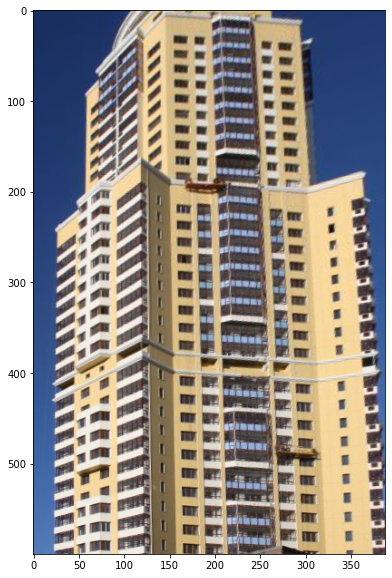

In [20]:
render_image(apply_xy_rotation(image, t_x, t_y, phi_x, phi_y))